# Titanic: Machine Learning from Disaster


Predict survival on the Titanic and get familiar with ML basics


Reference:
- [Mario Filho - Titanic](https://youtu.be/1UVizW6eFrY)
- [Sigmoidal - Titanic](https://sigmoidal.ai/data-science-titanic-python-1)
- [Improving the Random Forest](https://www.datasciencelearner.com/how-to-improve-accuracy-of-random-forest-classifier/)

In [249]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [250]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [251]:
# Load of files
gender_submission = pd.read_csv("../input/titanic/gender_submission.csv")
df_test = pd.read_csv("../input/titanic/test.csv")
df_train = pd.read_csv("../input/titanic/train.csv")

In [252]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


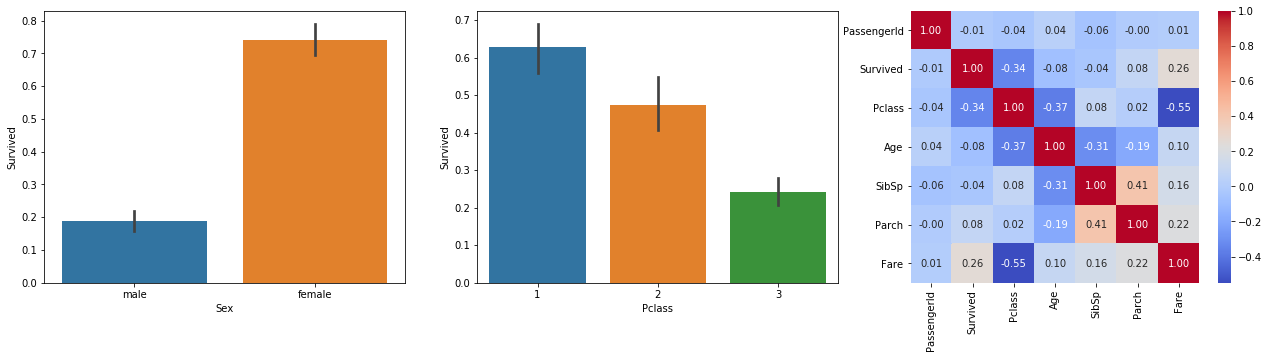

In [253]:
fig, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize=(22, 5))

correlation = df_train.corr()

sns.barplot(x='Sex', y='Survived', data=df_train, ax=axis1);
sns.barplot(x='Pclass', y='Survived', data=df_train, ax=axis2);
sns.heatmap(correlation, cmap='coolwarm', fmt='.2f', annot=True, ax=axis3);

### DataFrame: Assemble, Features & Null values

In [254]:
# Store the index of elemments before merge
train_idx = df_train.shape[0]
test_idx = df_test.shape[0]

# Copy the feature 'PassengerId' to use in the submit
column_PassengerId = df_test['PassengerId']

# Copy and remove the feature 'Survived'
column_Survived = df_train['Survived'].copy()
df_train.drop(['Survived'], axis=1, inplace=True)

# Create a new dataframe as merge
df_merged = pd.concat(objs=[df_train, df_test], axis=0).reset_index(drop=True)

# Features selected
features = ['Sex', 'Age', 'Pclass', 'SibSp', 'Parch', 'Fare']
df_merged = df_merged[features]

# Display the sum of null values in the dataframe
df_merged.isnull().sum()

Sex         0
Age       263
Pclass      0
SibSp       0
Parch       0
Fare        1
dtype: int64

### DataFrame: Feature engineer

In [255]:
age_median = df_merged['Age'].median()
df_merged['Age'].fillna(age_median, inplace=True)

fare_median = df_merged['Fare'].median()
df_merged['Fare'].fillna(age_median, inplace=True)

In [256]:
# Define a numeric value for the sex
def convert_sex(value):
    if value == 'female':
        return 1
    else:
        return 0

# Append a new column with the numeric value for the sex
df_merged['Sex_binary'] = df_merged['Sex'].map(convert_sex)
df_merged.drop(['Sex'], axis=1, inplace=True)

df_merged.head()

,Age,Pclass,SibSp,Parch,Fare,Sex_binary
0,22.0,3,1,0,7.2500,0
1,38.0,1,1,0,71.2833,1
2,26.0,3,0,0,7.9250,1
3,35.0,1,1,0,53.1000,1
4,35.0,3,0,0,8.0500,0


### DataFrame: Train & Test

In [257]:
df_train = df_merged.iloc[:train_idx]
df_test = df_merged.iloc[train_idx:]

print(df_train.shape)
print(df_test.shape)

(891, 6)
(418, 6)


## Definitions: features, train, valid

In [258]:
# Selection the features, add default value and define the target feature
X = df_train
y = column_Survived

# Split train and test
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3)

## Build Model - KFold

In [259]:
# Cross validation
results = []
rkf = RepeatedKFold(n_splits=2, n_repeats=10, random_state=9)

best_accuracy = 0
best_model = None

for line_train, line_test in rkf.split(X):
    # Load the group of data
    X_train, X_valid = X.iloc[line_train], X.iloc[line_test]
    y_train, y_valid = y.iloc[line_train], y.iloc[line_test]
    
    model = LogisticRegression()
    model.fit(X_train, y_train)
    
    y_predict = model.predict(X_valid)
    accuracy = np.mean(y_valid == y_predict)
    
    results.append(accuracy)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
  
print("Mean accuracy:", np.mean(results))
print("Best accuracy:", best_accuracy)

y_predicts_rkf = best_model.predict(df_test)

# Convert in Series
y_series = pd.Series(y_predicts_rkf, index=column_PassengerId, name="Survived")

# Write a csv file
y_series.to_csv("regression_model_rkf.csv", header=True)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Mean accuracy: 0.7950586990477151
Best accuracy: 0.8183856502242153


## Build Model - RandomForestClassifier

In [260]:
# Build model
model_rfc = RandomForestClassifier(n_estimators=100, n_jobs=1, random_state=0, max_depth=6)

# Fit the model
model_rfc.fit(X, y)

# Predict
y_predicts_rfc = model_rfc.predict(df_test)

# Accuracy
accuracy = round(model_rfc.score(X, y) * 100, 2)
print('Accuracy:', accuracy)

# Convert in Series
y_series = pd.Series(y_predicts_rfc, index=column_PassengerId, name="Survived")

# Write a csv file
y_series.to_csv("regression_model_rfc.csv", header=True)

Accuracy: 86.64


## Build Model - LogisticRegression

In [261]:
# Build model
model_lg = LogisticRegression()

# Fit the model
model_lg.fit(X, y)

# Predict the result
y_predicts_lg = model_lg.predict(df_test)

# Accuracy
accuracy = round(model_lg.score(X, y) * 100, 2)
print('Accuracy:', accuracy)

# Convert in Series
y_series = pd.Series(y_predicts_lg, index=column_PassengerId, name="Survived")

# Write a csv file
y_series.to_csv("regression_model_lg.csv", header=True)

Accuracy: 79.57


## Build Model - DecisionTree

In [262]:
# Build model
model_dtc = DecisionTreeClassifier(max_depth = 3)

# Fit the model
model_dtc.fit(X, y)

# Predict the result
y_predicts_dtc = model_dtc.predict(df_test)

# Accuracy
accuracy = round(model_dtc.score(X, y) * 100, 2)
print('Accuracy:', accuracy)

# Convert in Series
y_series = pd.Series(y_predicts_lg, index=column_PassengerId, name="Survived")

# Write a csv file
y_series.to_csv("regression_model_dtc.csv", header=True)

Accuracy: 82.72


## Build Model - GridSearch

In [264]:
parameters = {
    'n_estimators':[5, 10, 50, 100, 250],
    'max_depth':[2, 4, 6, 8, 16, 32, None]
}

model_gs_rfc = RandomForestClassifier()

grid_search = GridSearchCV(model_gs_rfc, parameters, cv=5)
grid_search.fit(X, y)

def get_best_params(grid):
    mean_score = grid.cv_results_['mean_test_score']
    std_score = grid.cv_results_['std_test_score']
    params = grid.cv_results_['params']
    
    best_mean = 0
    best_std = -99
    best_params = None
    for mean,std,params in zip(mean_score,std_score,params):
        if mean > best_mean:
            best_params = params
            best_mean = mean
            best_std = std
            
    print('Best mean:', best_mean)
    print('Best std:', best_std)
    print('Best params:', best_params)
    return best_params 
        
get_best_params(grid_search)

Best mean: 0.8294457347310276
Best std: 0.026171056269222396
Best params: {'max_depth': 8, 'n_estimators': 250}


{'max_depth': 8, 'n_estimators': 250}

In [266]:
# Build model
model_gs_rfc = RandomForestClassifier(n_estimators=250, n_jobs=1, max_depth=8)

# Fit the model
model_gs_rfc.fit(X, y)

# Predict
y_predicts_gs_rfc = model_gs_rfc.predict(df_test)

# Accuracy
accuracy = round(model_gs_rfc.score(X, y) * 100, 2)
print('Accuracy:', accuracy)

# Convert in Series
y_series = pd.Series(y_predicts_gs_rfc, index=column_PassengerId, name="Survived")

# Write a csv file
y_series.to_csv("regression_model_gs_rfc.csv", header=True)

Accuracy: 90.68
